In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
# laod JSON
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# clean and tokenize captions
def clean_caption(caption):
    tokens = caption.lower().split()
    return tokens

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<BOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold
        
    def get_vocab_size(self):
        return len(self.stoi)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4  
        for sentence in sentence_list:
            for word in sentence:
                frequencies[word] += 1
            
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = clean_caption(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

class VideoCaptionDataset(Dataset):
    def __init__(self, features_dir, annotations, vocab, max_length, transform=None):
        self.features_dir = features_dir
        self.annotations = annotations
        self.vocab = vocab
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        caption_data = self.annotations[index]
        caption_list = caption_data['caption']
        img_id = caption_data['id']
        img_path = f"{self.features_dir}/{img_id}.npy"
        video_features = np.load(img_path)
        if index == 0:
            print(f"Example video features shape: {video_features.shape}")
        
        #random caption for training
        caption = np.random.choice(caption_list)
        numericalized_caption = [self.vocab.stoi["<BOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]
        padded_caption = numericalized_caption + [self.vocab.stoi["<PAD>"]] * (self.max_length - len(numericalized_caption))

        #print(f"Random caption: {caption}")
        #print(f"Original caption length (including <BOS> and <EOS>): {len(numericalized_caption)}")
        #print(f"Padded caption length: {len(padded_caption)}")
        #print(f"Padded caption: {padded_caption}")
        #print(f"Video ID: {img_id}")
        #print(f"Selected Caption: {caption}")
        #print(f"Numericalized Caption: {numericalized_caption}")
        #print(f"Padded Caption: {padded_caption}")
        #print(f"Video Feature Path: {img_path}")
        
        if self.transform:
            video_features = self.transform(video_features)

        return torch.tensor(video_features, dtype=torch.float), torch.tensor(padded_caption, dtype=torch.long)

def generate_caption(model, video_features, vocab, max_length):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([vocab.stoi["<BOS>"]], device=video_features.device)
        
        generated_caption_indices = []
        
        for _ in range(max_length):
            # forwar pass
            #print('input id ', input_ids)
            outputs = model(video_features, input_ids)
            #print(max_length)
            #print(outputs)
            # use last word for sequence
            next_word_id = outputs[0, -1].argmax(0)
            #print(f"next_word_id: {next_word_id}")
            #print(f"next_word_id: {next_word_id.item()}")
            
            generated_caption_indices.append(next_word_id.item())
            
            print("Input ids:")
            for idx in input_ids:
                token = vocab.itos[idx.item()]
                print(token, end=" ") 
            print()

            input_ids = torch.cat([input_ids, next_word_id.unsqueeze(0)])

            print("Updated input ids:")
            for idx in input_ids:
                token = vocab.itos[idx.item()]
                print(token, end=" ")
            print()
            
            if next_word_id == vocab.stoi["<EOS>"]:
                break
        
        generated_caption = ' '.join([vocab.itos[idx] for idx in generated_caption_indices if idx in vocab.itos])
    return generated_caption


# train files
features_dir = '../S2VT_assignment/MLDS_hw2_1_data/training_data/feat'
training_data = load_json('../S2VT_assignment/MLDS_hw2_1_data/training_label.json')

# flatten captions
all_captions = [caption for item in training_data for caption in item['caption']]

# token the captions 
tokenized_captions = [clean_caption(caption) for caption in all_captions]
#print(tokenized_captions)

# build the vocab w/ threshold
vocab = Vocabulary(freq_threshold=3)
vocab.build_vocabulary(tokenized_captions)
caption_example = training_data[0]['caption'][0]
tokens_example = clean_caption(caption_example)
numericalized_example = vocab.numericalize(caption_example)
print(f"Original: {caption_example}")
print(f"Tokenized: {tokens_example}")
print(f"Numericalized: {numericalized_example}")


# create max length for caption padding
max_caption_length = max(len(clean_caption(c)) for c in all_captions) + 2
print(f"Max caption length: {max_caption_length}")

dataset = VideoCaptionDataset(features_dir, training_data, vocab, max_caption_length)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# checking
for video_features, captions in data_loader:
    print(f"Batch video features shape: {video_features.shape}")
    print(f"Batch captions shape: {captions.shape}")
    break


Original: A woman goes under a horse.
Tokenized: ['a', 'woman', 'goes', 'under', 'a', 'horse.']
Numericalized: [4, 7, 18, 12, 4, 20]
Max caption length: 42
Batch video features shape: torch.Size([32, 80, 4096])
Batch captions shape: torch.Size([32, 42])


In [3]:
#print vocab
 #   print(f"{word}: {index}")

In [4]:
class S2VTModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, vocab_size, max_seq_length=41):
        super(S2VTModel, self).__init__()
        self.encoder_lstm = nn.LSTM(feature_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.5)
        
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, video_features, captions=None):
        # encoding
        _, (hidden, _) = self.encoder_lstm(video_features)

        # decoding
        outputs = []
        step_input = torch.zeros(video_features.size(0), 1, hidden.size(2)).to(video_features.device)
        for _ in range(self.max_seq_length):
            output, (hidden, _) = self.decoder_lstm(step_input, (hidden, hidden))
            step_input = output
            output = self.fc(output.squeeze(1))
            outputs.append(output)
        outputs = torch.stack(outputs, 1)

        return outputs

In [5]:
vocab_size = vocab.get_vocab_size() 
feature_dim = 4096 #this is preset by input features, change for TA test?
hidden_dim = 500
model = S2VTModel(feature_dim, hidden_dim, vocab_size)
print(model)

S2VTModel(
  (encoder_lstm): LSTM(4096, 500, num_layers=2, batch_first=True, dropout=0.5)
  (decoder_lstm): LSTM(500, 500, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=500, out_features=3529, bias=True)
)


In [6]:
#Use cuda, set up model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

# set optimzer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

#some variables
num_epochs = 30

In [7]:
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (video_features, captions) in enumerate(data_loader):
        video_features, captions = video_features.to(device), captions.to(device)
    
        # forward pass
        outputs = model(video_features, captions[:, :-1])
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].reshape(-1))
        
        #see predictions for model progress
        if batch_idx == 0 and (epoch % 5 == 0):
            print("Epoch:", epoch + 1)
            logits = outputs[0, :, :]
            predicted_indices = logits.argmax(dim=1)
            predicted_tokens = [vocab.itos[idx.item()] for idx in predicted_indices]
            
            # ground truth
            ground_truth_indices = captions[0, 1:]
            ground_truth_tokens = [vocab.itos[idx.item()] for idx in ground_truth_indices]
            
            print("Predicted:", predicted_tokens)
            print("Ground Truth:", ground_truth_tokens)
        
        # optimze, backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        #scheduler.step()
        avg_loss = total_loss / len(data_loader)
        epoch_losses.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
    

Example video features shape: (80, 4096)
Epoch: 1
Predicted: ['wave.', 'wave.', 'wave.', 'wave.', 'falling.', 'falling.', 'falling.', 'form', 'falling.', 'form', 'falling.', 'angrily', 'falling.', 'outfit', 'falling.', 'falling.', 'form', 'falling.', 'falling.', 'falling.', 'form', 'falling.', 'falling.', 'angrily', 'form', 'falling.', 'falling.', 'falling.', 'falling.', 'falling.', 'falling.', 'falling.', 'outfit', 'falling.', 'form', 'outfit', 'outfit', 'form', 'falling.', 'falling.', 'falling.']
Ground Truth: ['women', 'are', 'leaving', 'a', 'cab.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Epoch [1/30], Loss: 7.303551539130833
Example video features shape: (80, 4096)
Epoch [2/30], Loss: 5.13406401095183
E

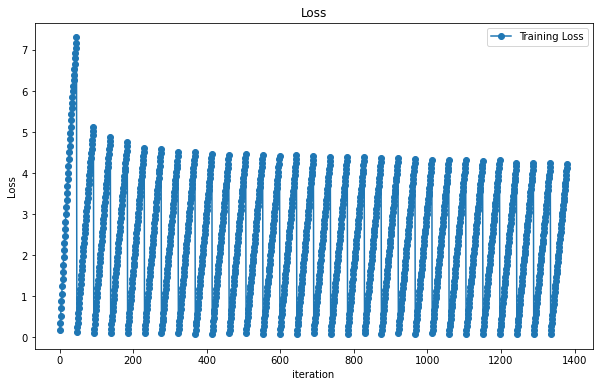

In [8]:
# Plot
epochs = range(1, len(epoch_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_losses, marker='o', label='Training Loss')
plt.title('Loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
torch.save(model.state_dict(),"s2vt3_model.pth")

In [10]:
class VideoCaptionDatasetTest(Dataset):
    def __init__(self, features_dir, annotations):
        self.features_dir = features_dir
        self.annotations = annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations[index]['id']
        img_path = f"{self.features_dir}/{img_id}.npy"
        test_video_features = np.load(img_path)

        return torch.tensor(test_video_features, dtype=torch.float), img_id

#test annotations
test_annotations = load_json('../S2VT_assignment/MLDS_hw2_1_data/testing_label.json')

# test dataset and loader
test_dataset = VideoCaptionDatasetTest('../S2VT_assignment/MLDS_hw2_1_data/testing_data/feat', test_annotations)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
max_length = 20

In [11]:
model = S2VTModel(feature_dim, hidden_dim, vocab_size)
model.load_state_dict(torch.load("s2vt3_model.pth", map_location=device))
model = model.to(device)
model.eval()

S2VTModel(
  (encoder_lstm): LSTM(4096, 500, num_layers=2, batch_first=True, dropout=0.5)
  (decoder_lstm): LSTM(500, 500, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=500, out_features=3529, bias=True)
)

In [12]:
with torch.no_grad():
    for i, (test_video_features, _) in enumerate(data_loader):
        test_video_features = test_video_features.to(device)
        #print(f"Shape of video features before passing to generate_caption: {test_video_features.shape}")

        generated_caption = generate_caption(model, test_video_features, vocab, max_length)

        # ground truth for printing
        ground_truth_captions = test_annotations[i]['caption']
        random_index = np.random.randint(0, len(ground_truth_captions))
        ground_truth_caption = ground_truth_captions[random_index]

        video_file_path = test_annotations[i]['id']

        print(f"Video file path: {video_file_path}")
        print(f"Ground truth caption: {ground_truth_caption}")
        print(f"Generated caption: {generated_caption}")


Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: ScdUht-pM6s_53_63.avi
Ground truth caption: A man making a chicken
Generated caption: <EOS>
Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: wkgGxsuNVSg_34_41.avi
Ground truth caption: A little kid is running around a fishing pole.
Generated caption: <EOS>
Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: BtQtRGI0F2Q_15_20.avi
Ground truth caption: A man is getting electrocuted on a power poll.
Generated caption: <EOS>
Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: k06Ge9ANKM8_5_16.avi
Ground truth caption: A dog is playing balloons.
Generated caption: <EOS>
Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: sZf3VDsdDPM_107_114.avi
Ground truth caption: A man is eating his food.
Generated caption: <EOS>
Input ids:
<BOS> 
Updated input ids:
<BOS> <EOS> 
Video file path: shPymuahrsc_5_12.avi
Ground truth caption: A slow lori walks around.
Generated cap